In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from helper_functions import *

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [3]:
# Check files in local folder
comp_results = [x for x in os.listdir('results') if x.startswith('duopoly_competition_details')]
comp_results

['duopoly_competition_details_20211124.csv',
 'duopoly_competition_details_20211125.csv',
 'duopoly_competition_details_20211126.csv',
 'duopoly_competition_details_20211127.csv',
 'duopoly_competition_details_20211128.csv',
 'duopoly_competition_details_20211129.csv',
 'duopoly_competition_details_20211130.csv',
 'duopoly_competition_details_20211201.csv',
 'duopoly_competition_details_20211202.csv']

In [4]:
# Load data
start_date, end_date = '2021-11-24', '2021-12-02'#pd.to_datetime('today').strftime("%Y-%m-%d")

data = load_results(start_date, end_date)
data = remove_incomplete_seasons(data)

Loaded 428571 rows of data for 20211124
Loaded 435134 rows of data for 20211125
Loaded 485823 rows of data for 20211126
Loaded 450000 rows of data for 20211127
Loaded 500000 rows of data for 20211128
Loaded 500000 rows of data for 20211129
Loaded 500000 rows of data for 20211130
Loaded 400000 rows of data for 20211201


C:\Users\u02vpe\Anaconda3\envs\dynamic_pricing_comp\lib\site-packages\ipykernel_launcher.py:4: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


Loaded 450000 rows of data for 20211202


In [5]:
data.shape

(4146000, 11)

In [6]:
data['loadfactor'] = data.groupby(['competition_id', 'selling_season'])['demand'].cumsum() / 80 * 100
data = data[(data['loadfactor'] < 100) | (data['demand'] > 0)]

In [7]:
# Make lag based features
for col in ['price_competitor', 'price', 'demand', 'competitor_has_capacity']:
    for i in range(1, 11):
        data[col + '_t-' + str(i)] = data.groupby(['competition_id', 'selling_season'])[col].shift(i)

In [8]:
for i in range(1, 11):
    data['price_diff_t-' + str(i)] = data['price_competitor_t-' + str(i)] - data['price_t-' + str(i)]

In [13]:
# capacity_cols = [col for col in data.columns if col.startswith('competitor_has_capacity')]
# data[capacity_cols] = data[capacity_cols].fillna(True)

In [9]:
data = data[data['selling_period'] > 10]

In [10]:
data.shape

(2506795, 62)

In [11]:
data.isna().sum()

competition_id                        0
selling_season                        0
selling_period                        0
competitor_id                         0
price_competitor                      0
price                                 0
demand                                0
competitor_has_capacity               0
calculation_duration                  0
errors                          2506042
date                                  0
loadfactor                            0
price_competitor_t-1                  0
price_competitor_t-2                  0
price_competitor_t-3                  0
price_competitor_t-4                  0
price_competitor_t-5                  0
price_competitor_t-6                  0
price_competitor_t-7                  0
price_competitor_t-8                  0
price_competitor_t-9                  0
price_competitor_t-10                 0
price_t-1                             0
price_t-2                             0
price_t-3                             0


In [16]:
data.head()

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors,date,loadfactor,price_competitor_t-1,price_competitor_t-2,price_competitor_t-3,price_competitor_t-4,price_competitor_t-5,price_competitor_t-6,price_competitor_t-7,price_competitor_t-8,price_competitor_t-9,price_competitor_t-10,price_t-1,price_t-2,price_t-3,price_t-4,price_t-5,price_t-6,price_t-7,price_t-8,price_t-9,price_t-10,demand_t-1,demand_t-2,demand_t-3,demand_t-4,demand_t-5,demand_t-6,demand_t-7,demand_t-8,demand_t-9,demand_t-10,competitor_has_capacity_t-1,competitor_has_capacity_t-2,competitor_has_capacity_t-3,competitor_has_capacity_t-4,competitor_has_capacity_t-5,competitor_has_capacity_t-6,competitor_has_capacity_t-7,competitor_has_capacity_t-8,competitor_has_capacity_t-9,competitor_has_capacity_t-10,price_diff_t-1,price_diff_t-2,price_diff_t-3,price_diff_t-4,price_diff_t-5,price_diff_t-6,price_diff_t-7,price_diff_t-8,price_diff_t-9,price_diff_t-10
10,g9GQfa,1,11,InterestingHamster,34.00,35.10,1,True,0.00,NaN,20211124,38.75,54.40,37.90,55.20,49.90,55.40,35.30,50.90,32.10,33.80,38.60,34.50,34.00,33.50,33.00,32.50,32.00,31.50,31.00,30.50,30.00,4.00,2.00,3.00,2.00,6.00,1.00,5.00,4.00,2.00,1.00,True,True,True,True,True,True,True,True,True,True,19.90,3.90,21.70,16.90,22.90,3.30,19.40,1.10,3.30,8.60
11,g9GQfa,1,12,InterestingHamster,34.50,35.60,1,True,0.00,NaN,20211124,40.00,34.00,54.40,37.90,55.20,49.90,55.40,35.30,50.90,32.10,33.80,35.10,34.50,34.00,33.50,33.00,32.50,32.00,31.50,31.00,30.50,1.00,4.00,2.00,3.00,2.00,6.00,1.00,5.00,4.00,2.00,True,True,True,True,True,True,True,True,True,True,-1.10,19.90,3.90,21.70,16.90,22.90,3.30,19.40,1.10,3.30
12,g9GQfa,1,13,InterestingHamster,35.10,36.10,1,True,0.00,NaN,20211124,41.25,34.50,34.00,54.40,37.90,55.20,49.90,55.40,35.30,50.90,32.10,35.60,35.10,34.50,34.00,33.50,33.00,32.50,32.00,31.50,31.00,1.00,1.00,4.00,2.00,3.00,2.00,6.00,1.00,5.00,4.00,True,True,True,True,True,True,True,True,True,True,-1.10,-1.10,19.90,3.90,21.70,16.90,22.90,3.30,19.40,1.10
13,g9GQfa,1,14,InterestingHamster,35.60,36.60,0,True,0.00,NaN,20211124,41.25,35.10,34.50,34.00,54.40,37.90,55.20,49.90,55.40,35.30,50.90,36.10,35.60,35.10,34.50,34.00,33.50,33.00,32.50,32.00,31.50,1.00,1.00,1.00,4.00,2.00,3.00,2.00,6.00,1.00,5.00,True,True,True,True,True,True,True,True,True,True,-1.00,-1.10,-1.10,19.90,3.90,21.70,16.90,22.90,3.30,19.40
14,g9GQfa,1,15,InterestingHamster,36.10,37.10,1,True,0.00,NaN,20211124,42.50,35.60,35.10,34.50,34.00,54.40,37.90,55.20,49.90,55.40,35.30,36.60,36.10,35.60,35.10,34.50,34.00,33.50,33.00,32.50,32.00,0.00,1.00,1.00,1.00,4.00,2.00,3.00,2.00,6.00,1.00,True,True,True,True,True,True,True,True,True,True,-1.00,-1.00,-1.10,-1.10,19.90,3.90,21.70,16.90,22.90,3.30


In [17]:
data[(data['competition_id'] == 'g9GQfa') & (data['selling_season'] <= 3)]

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors,date,loadfactor,price_competitor_t-1,price_competitor_t-2,price_competitor_t-3,price_competitor_t-4,price_competitor_t-5,price_competitor_t-6,price_competitor_t-7,price_competitor_t-8,price_competitor_t-9,price_competitor_t-10,price_t-1,price_t-2,price_t-3,price_t-4,price_t-5,price_t-6,price_t-7,price_t-8,price_t-9,price_t-10,demand_t-1,demand_t-2,demand_t-3,demand_t-4,demand_t-5,demand_t-6,demand_t-7,demand_t-8,demand_t-9,demand_t-10,competitor_has_capacity_t-1,competitor_has_capacity_t-2,competitor_has_capacity_t-3,competitor_has_capacity_t-4,competitor_has_capacity_t-5,competitor_has_capacity_t-6,competitor_has_capacity_t-7,competitor_has_capacity_t-8,competitor_has_capacity_t-9,competitor_has_capacity_t-10,price_diff_t-1,price_diff_t-2,price_diff_t-3,price_diff_t-4,price_diff_t-5,price_diff_t-6,price_diff_t-7,price_diff_t-8,price_diff_t-9,price_diff_t-10
10,g9GQfa,1,11,InterestingHamster,34.00,35.10,1,True,0.00,NaN,20211124,38.75,54.40,37.90,55.20,49.90,55.40,35.30,50.90,32.10,33.80,38.60,34.50,34.00,33.50,33.00,32.50,32.00,31.50,31.00,30.50,30.00,4.00,2.00,3.00,2.00,6.00,1.00,5.00,4.00,2.00,1.00,True,True,True,True,True,True,True,True,True,True,19.90,3.90,21.70,16.90,22.90,3.30,19.40,1.10,3.30,8.60
11,g9GQfa,1,12,InterestingHamster,34.50,35.60,1,True,0.00,NaN,20211124,40.00,34.00,54.40,37.90,55.20,49.90,55.40,35.30,50.90,32.10,33.80,35.10,34.50,34.00,33.50,33.00,32.50,32.00,31.50,31.00,30.50,1.00,4.00,2.00,3.00,2.00,6.00,1.00,5.00,4.00,2.00,True,True,True,True,True,True,True,True,True,True,-1.10,19.90,3.90,21.70,16.90,22.90,3.30,19.40,1.10,3.30
12,g9GQfa,1,13,InterestingHamster,35.10,36.10,1,True,0.00,NaN,20211124,41.25,34.50,34.00,54.40,37.90,55.20,49.90,55.40,35.30,50.90,32.10,35.60,35.10,34.50,34.00,33.50,33.00,32.50,32.00,31.50,31.00,1.00,1.00,4.00,2.00,3.00,2.00,6.00,1.00,5.00,4.00,True,True,True,True,True,True,True,True,True,True,-1.10,-1.10,19.90,3.90,21.70,16.90,22.90,3.30,19.40,1.10
13,g9GQfa,1,14,InterestingHamster,35.60,36.60,0,True,0.00,NaN,20211124,41.25,35.10,34.50,34.00,54.40,37.90,55.20,49.90,55.40,35.30,50.90,36.10,35.60,35.10,34.50,34.00,33.50,33.00,32.50,32.00,31.50,1.00,1.00,1.00,4.00,2.00,3.00,2.00,6.00,1.00,5.00,True,True,True,True,True,True,True,True,True,True,-1.00,-1.10,-1.10,19.90,3.90,21.70,16.90,22.90,3.30,19.40
14,g9GQfa,1,15,InterestingHamster,36.10,37.10,1,True,0.00,NaN,20211124,42.50,35.60,35.10,34.50,34.00,54.40,37.90,55.20,49.90,55.40,35.30,36.60,36.10,35.60,35.10,34.50,34.00,33.50,33.00,32.50,32.00,0.00,1.00,1.00,1.00,4.00,2.00,3.00,2.00,6.00,1.00,True,True,True,True,True,True,True,True,True,True,-1.00,-1.00,-1.10,-1.10,19.90,3.90,21.70,16.90,22.90,3.30
15,g9GQfa,1,16,InterestingHamster,36.60,37.60,1,True,0.00,NaN,20211124,43.75,36.10,35.60,35.10,34.50,34.00,54.40,37.90,55.20,49.90,55.40,37.10,36.60,36.10,35.60,35.10,34.50,34.00,33.50,33.00,32.50,1.00,0.00,1.00,1.00,1.00,4.00,2.00,3.00,2.00,6.00,True,True,True,True,True,True,True,True,True,True,-1.00,-1.00,-1.00,-1.10,-1.10,19.90,3.90,21.70,16.90,22.90
16,g9GQfa,1,17,InterestingHamster,37.10,38.10,0,True,0.00,NaN,20211124,43.75,36.60,36.10,35.60,35.10,34.50,34.00,54.40,37.90,55.20,49.90,37.60,37.10,36.60,36.10,35.60,35.10,34.50,34.00,33.50,33.00,1.00,1.00,0.00,1.00,1.00,1.00,4.00,2.00,3.00,2.00,True,True,True,True,True,True,True,True,True,True,-1.00,-1.00,-1.00,-1.00,-1.10,-1.10,19.90,3.90,21.70,16.90
17,g9GQfa,1,18,InterestingHamster,37.60,38.60,4,True,0.00,NaN,20211124,48.75,37.10,36.60,36.10,35.60,35.10,34.50,34.00,54.40,37.90,55.20,38.10,37.60,37.10,36.60,36.10,35.60,35.10,34.50,34.00,33.50,0.00,1.00,1.00,0.00,1.00,1.00,1.00,4.00,2.00,3.00,True,True,True,True,True,True,True,True,True,True,-1.00,-1.00,-1.00,-1.00,-1.00,-1.10,-1.10,19.90,3.90,21.70
18,g9GQfa,1,19,InterestingHamster,38.10,39.10,1,True,0.00,NaN,20211124,50.00,37.60,37.10,36.60,36.10,35.60,35.10,34.50,34.00,54.40,37.90,38.60,38.10,3

In [18]:
data[[
    'selling_season', 
    'selling_period', 
    'price_competitor_t-1', 
    'price_diff_t-1',
    'price', 
    'competitor_has_capacity', 
    'demand']].describe()

,selling_season,selling_period,price_competitor_t-1,price_diff_t-1,price,demand
count,2506795.00,2506795.00,2506795.00,2506795.00,2506795.00,2506795.00
mean,50.45,46.76,116.21,63.88,52.61,0.96
std,28.88,24.74,242.81,244.56,10.43,1.20
min,1.00,11.00,0.10,-79.40,2.00,0.00
25%,25.00,26.00,43.10,-2.90,46.00,0.00
50%,51.00,43.00,52.00,-0.50,50.70,1.00
75%,76.00,66.00,60.00,2.80,58.80,2.00
max,100.00,100.00,998.00,963.50,80.00,12.00


In [12]:
data[[
    'selling_season', 
    'selling_period', 
    'price_competitor_t-1',
    'price_diff_t-1',
    'price', 
    'competitor_has_capacity', 
    'demand']].corr()

,selling_season,selling_period,price_competitor_t-1,price_diff_t-1,price,competitor_has_capacity,demand
selling_season,1.00,-0.00,-0.00,-0.00,-0.00,-0.02,-0.00
selling_period,-0.00,1.00,-0.22,-0.25,0.73,-0.43,-0.35
price_competitor_t-1,-0.00,-0.22,1.00,1.00,-0.15,0.13,0.18
price_diff_t-1,-0.00,-0.25,1.00,1.00,-0.19,0.14,0.20
price,-0.00,0.73,-0.15,-0.19,1.00,-0.41,-0.45
competitor_has_capacity,-0.02,-0.43,0.13,0.14,-0.41,1.00,0.15
demand,-0.00,-0.35,0.18,0.20,-0.45,0.15,1.00


In [13]:
X = data[['selling_period', 'price_competitor_t-1', 'price', 'competitor_has_capacity']]
y = data['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # Fill na's
# median_open_price= X_train.loc[X_train['selling_period'] == 2, 'price_competitor_t-1'].median()
# X_train['price_competitor_t-1'] = X_train['price_competitor_t-1'].fillna(median_open_price)
# X_test['price_competitor_t-1'] = X_test['price_competitor_t-1'].fillna(median_open_price)

<AxesSubplot:xlabel='demand', ylabel='Count'>

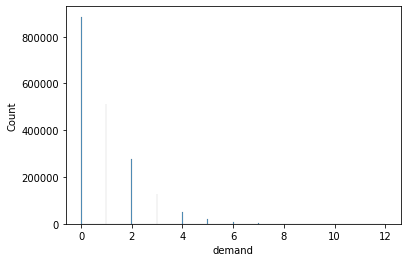

In [14]:
sns.histplot(y_train)

In [15]:
# baseline 1: mean/median
train_mean = y_train.mean()
train_median = y_train.median()

print(f'Mean: {train_mean}')
print(f'Median: {train_median}')

Mean: 0.9601025692305074
Median: 1.0


In [16]:
mean_rmse = np.sqrt(mean_squared_error(y_test, np.repeat(train_mean, len(y_test))))
median_rmse = np.sqrt(mean_squared_error(y_test, np.repeat(train_median, len(y_test))))

print(f'Mean rmse: {mean_rmse}')
print(f'Median rmse: {median_rmse}')

Mean rmse: 1.2047455654405506
Median rmse: 1.2054318667702544


In [24]:
# Baseline 2: avg at dbd
X_train_c = X_train.copy()
X_train_c['demand'] = y_train
avg_demand_dbd = X_train_c.groupby('selling_period').agg({'demand': 'mean'})

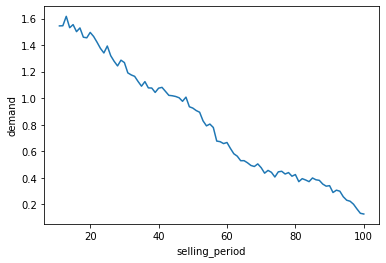

In [25]:
# Doesnt work due to past strategy
_ = sns.lineplot(x=avg_demand_dbd.index, y=avg_demand_dbd['demand'])

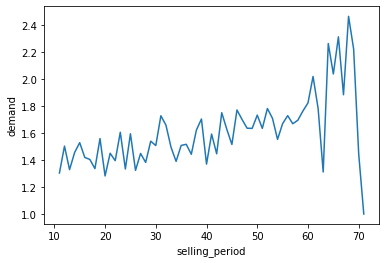

In [26]:
# Interesting insight but not useful as baseline
test_flatprice = data[data['date'] == '20211130'].groupby('selling_period').agg({'demand': 'mean'})

_ = sns.lineplot(x=test_flatprice.index, y=test_flatprice['demand'])

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
preds[preds < 0] = 0

In [ ]:
plt.title(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 3)}')
_ = sns.histplot(preds)

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
preds[preds < 0] = 0

In [ ]:
plt.title(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 3)}')
_ = sns.histplot(preds)

In [ ]:
# Add price diff
X = data[['selling_period', 'price_competitor_t-1', 'price', 'price_diff_t-1', 'competitor_has_capacity']]
y = data['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
preds[preds < 0] = 0

plt.title(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 3)}')
_ = sns.histplot(preds)
# No diff

In [ ]:
for col in [x for x in data.columns if x.startswith('competitor_has_capacity')]:
    data[col] = data[col].astype(int)

In [ ]:
X = data[[
    'selling_period', 
    'price_competitor_t-1', 
    'price', 
    'competitor_has_capacity',
    'demand_t-1',
    'demand_t-2',
    'demand_t-3',
    'demand_t-4',
    'demand_t-5',
    'demand_t-6',
    'demand_t-7',
    'demand_t-8',
    'demand_t-9',
    'demand_t-10',
#     'price_t-1',
#     'price_t-2',
#     'price_t-3',
#     'price_t-4',
#     'price_t-5',
#     'price_t-6',
#     'price_t-7',
#     'price_t-8',
#     'price_t-9',
#     'price_t-10',
#     'price_competitor_t-2',
#     'price_competitor_t-3',
#     'price_competitor_t-4',
#     'price_competitor_t-5',
#     'price_competitor_t-6',
#     'price_competitor_t-7',
#     'price_competitor_t-8',
#     'price_competitor_t-9',
#     'price_competitor_t-10',
#     'competitor_has_capacity_t-1',
#     'competitor_has_capacity_t-2',
#     'competitor_has_capacity_t-3',
#     'competitor_has_capacity_t-4',
#     'competitor_has_capacity_t-5',
#     'competitor_has_capacity_t-6',
#     'competitor_has_capacity_t-7',
#     'competitor_has_capacity_t-8',
#     'competitor_has_capacity_t-9',
#     'competitor_has_capacity_t-10'
]]
y = data['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
preds[preds < 0] = 0

plt.title(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 3)}')
_ = sns.histplot(preds)

# Demand
# 1.042 (zonder)
# 1.037 (t-1)
# 1.029 (t-2)
# 1.022 (t-3)
# 1.017 (t-4)
# 1.014 (t-5)
# 1.007 (t-7)
# 0.999 (t-10)
# 0.999 + price
# 0.999 + comp_price

In [ ]:
for i in range(5):
    data['demand_t-' + str(1+i*2) + '-' + str(2+2*i)] = data['demand_t-' + str(1+i*2)] + data['demand_t-' + str(2+2*i)]
    data['price_t-' + str(1+i*2) + '-' + str(2+2*i)] = (data['price_t-' + str(1+i*2)] + data['price_t-' + str(2+2*i)]) /2
    data['price_competitor_t-' + str(1+i*2) + '-' + str(2+2*i)] = (data['price_competitor_t-' + str(1+i*2)] + data['price_competitor_t-' + str(2+2*i)]) /2
    data['competitor_has_capacity_t-' + str(1+i*2) + '-' + str(2+2*i)] = (data['competitor_has_capacity_t-' + str(1+i*2)] + data['competitor_has_capacity_t-' + str(2+2*i)]) /2

In [ ]:
data.head()

In [ ]:
X = data[[
    'selling_period', 
    'price_competitor_t-1', 
    'price', 
    'competitor_has_capacity',
    'demand_t-1-2',
    'demand_t-3-4',
    'demand_t-5-6',
    'demand_t-7-8',
    'demand_t-9-10',
#     'price_t-1',
#     'price_t-2',
#     'price_t-3',
#     'price_t-4',
#     'price_t-5',
#     'price_t-6',
#     'price_t-7',
#     'price_t-8',
#     'price_t-9',
#     'price_t-10',
#     'price_competitor_t-2',
#     'price_competitor_t-3',
#     'price_competitor_t-4',
#     'price_competitor_t-5',
#     'price_competitor_t-6',
#     'price_competitor_t-7',
#     'price_competitor_t-8',
#     'price_competitor_t-9',
#     'price_competitor_t-10',
#     'competitor_has_capacity_t-1',
#     'competitor_has_capacity_t-2',
#     'competitor_has_capacity_t-3',
#     'competitor_has_capacity_t-4',
#     'competitor_has_capacity_t-5',
#     'competitor_has_capacity_t-6',
#     'competitor_has_capacity_t-7',
#     'competitor_has_capacity_t-8',
#     'competitor_has_capacity_t-9',
#     'competitor_has_capacity_t-10'
]]
y = data['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
preds[preds < 0] = 0

plt.title(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 3)}')
_ = sns.histplot(preds)

In [ ]:
# Add features as aggregations of last x days
# Last days 1-7
# Last days 2-14 per 2d agg
# Last days 3-21 per 3d agg
# Last days 4-28 per 4d agg
# ... if needed
#
# Features for avg price, avg comp price, sum demand, comp has inv

In [ ]:
# Try SARIMA with exog vars

In [35]:
# try NN
import tensorflow as tf
import keras

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Embedding, Flatten, Concatenate
from keras.callbacks import Callback
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import StandardScaler

X = data[[
    'selling_period', 
    'price_competitor_t-1', 
    'price', 
    'competitor_has_capacity',
    'demand_t-1',
    'demand_t-2',
    'demand_t-3',
    'demand_t-4',
    'demand_t-5',
    'demand_t-6',
    'demand_t-7',
    'demand_t-8',
    'demand_t-9',
    'demand_t-10',
    'price_t-1',
    'price_t-2',
    'price_t-3',
    'price_t-4',
    'price_t-5',
    'price_t-6',
    'price_t-7',
    'price_t-8',
    'price_t-9',
    'price_t-10',
    'price_competitor_t-2',
    'price_competitor_t-3',
    'price_competitor_t-4',
    'price_competitor_t-5',
    'price_competitor_t-6',
    'price_competitor_t-7',
    'price_competitor_t-8',
    'price_competitor_t-9',
    'price_competitor_t-10',
    'competitor_has_capacity_t-1',
    'competitor_has_capacity_t-2',
    'competitor_has_capacity_t-3',
    'competitor_has_capacity_t-4',
    'competitor_has_capacity_t-5',
    'competitor_has_capacity_t-6',
    'competitor_has_capacity_t-7',
    'competitor_has_capacity_t-8',
    'competitor_has_capacity_t-9',
    'competitor_has_capacity_t-10'
]]
y = data['demand']

X_train, X_test, y_train, y_test = train_test_split(
    np.asarray(X).astype('float32'), np.array(y), test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

model = Sequential()
model.add(Dense(units=20, input_shape=(X_train.shape[1],), activation='relu', name='hidden_layer1'))
model.add(Dense(units=25, activation='relu', name='hidden_layer2'))
model.add(Dense(1, activation='relu', name='output_layer'))
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError()])

print(model.summary())

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test)
                   )

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 20)                880       
                                                                 
 hidden_layer2 (Dense)       (None, 25)                525       
                                                                 
 output_layer (Dense)        (None, 1)                 26        
                                                                 
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
29377/29377 [==============================] - 73s 2ms/step - loss: 1.0495 - root_mean_squared_error: 1.0244 - val_loss: 1.0373 - val_root_mean_squared_error: 1.0185oss: 1.0496 - root_m
Epoch 2/20
29377/29377 [==============================] - 72s 2ms/step - loss: 1.0308 - root_mean_squared_error: 1

KeyboardInterrupt: 

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1880096, 43), (626699, 43), (1880096,), (626699,))

In [33]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [ ]:
# Try LSTM

In [ ]:
# Check error at dbd to determine when to start predicting